## 掛載雲端硬碟


In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [26]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/Colab\ Notebooks/EAI_Lab4_2023

## Import library

In [27]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數(填空)

In [28]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = f'/ssd6/Roy/EAI_Lab4_2024_題目/lambda={LAMBDA}_model_best.pth'


In [29]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [30]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與載入訓練好的權重

In [31]:
model = vgg()
if CUDA:
    model.cuda()

##設定Optimizer，這裡使用Stocastic Gradient Descent

In [32]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##使用論文中稀疏化的方式更新參數(填空)

In [33]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
          # Sparsity Regularization using L1 norm
          m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data)) # lambda * sum(abs(gamma)) 的微分為 lambda * sign(gamma)


## 載入預先定義好的模型與參數

In [34]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

## 定義訓練跟測試函數

In [35]:
# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
train_acc_list = []  # 用於儲存每個 epoch 的訓練準確率
sparsity_list = []  # 用於儲存每個 epoch 的稀疏度

#### 計算稀疏度的函數 ####
def calculate_sparsity():
    total_weights = 0
    zero_weights = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total_weights += m.weight.numel()
            zero_weights += (m.weight.abs() < 1e-3).sum().item()  # 判斷接近零的 weight
    return zero_weights / total_weights  # Sparsity = 零值數量 / 總數量

#### 訓練函數 #####
def train(epoch):
    model.train()
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1, keepdim=True)[1]
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        train_total += target.size(0)

        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    
    # 計算當前 epoch 的訓練準確率並儲存
    train_accuracy = train_correct / train_total
    train_acc_list.append(train_accuracy)
    
    # 計算當前 epoch 的稀疏度並儲存
    sparsity = calculate_sparsity()
    sparsity_list.append(sparsity)
    
    print(f'Train Accuracy for Epoch {epoch}: {train_accuracy * 100:.2f}%')
    print(f'Sparsity for Epoch {epoch}: {sparsity * 100:.2f}%')


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.306274
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.908405
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.436649
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.521086
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.359287
Train Accuracy for Epoch 0: 42.51%
Sparsity for Epoch 0: 0.00%

Test set: Average loss: 1.3399, Accuracy: 5024/10000 (50.2%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.075159
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.056303
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.886360
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.902729
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.795209
Train Accuracy for Epoch 1: 63.94%
Sparsity for Epoch 1: 0.00%

Test set: Average loss: 1.2392, Accuracy: 5802/10000 (58.0%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.900046
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.780918
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.680941
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.917360
Train Epoch: 2 [40000/50000 (80.0%)

## 繪製Sparsity-Training結果圖

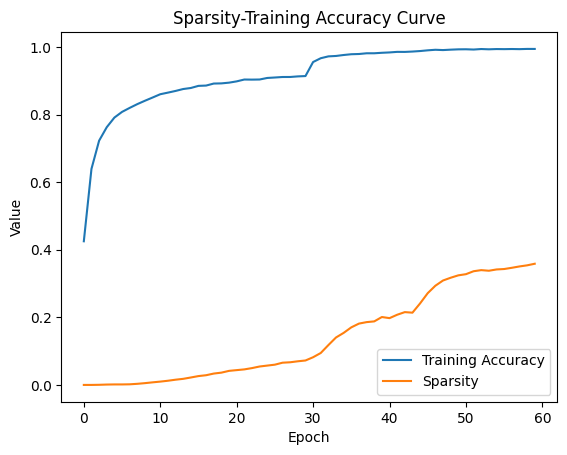

In [36]:
#繪製 Sparsity-Training 結果圖
# 在訓練過程完成後，可以使用 train_acc_list 和 sparsity_list 繪製訓練準確率與稀疏度變化圖
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(START_EPOCH, EPOCHS), train_acc_list, label='Training Accuracy')
plt.plot(range(START_EPOCH, EPOCHS), sparsity_list, label='Sparsity')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Sparsity-Training Accuracy Curve')
plt.legend()
plt.show()


## 繪製scaling factor 分布圖

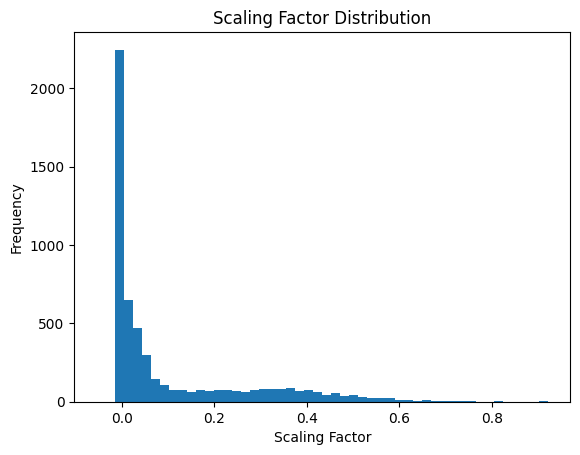

In [37]:
#繪製 scaling factor 分布圖
scaling_factors = []

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        scaling_factors.extend(m.weight.detach().cpu().numpy())  # 提取縮放因子

plt.figure()
plt.hist(scaling_factors, bins=50)
plt.xlabel('Scaling Factor')
plt.ylabel('Frequency')
plt.title('Scaling Factor Distribution')
plt.show()
